# Level 2: Validation Notebook

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Feature Engineering
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc

# API key
pc.settings.set_subscription_key('b1da7e1401f142dabe914a070031f981')

# Others
from datetime import datetime, timedelta
import datetime as dt
import pickle
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
test_file = pd.read_csv('Challenge_2_submission_template.csv')
test_file.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,NaN
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,NaN
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,NaN
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,NaN
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,NaN


In [3]:
def get_sentinel_data(longitude, latitude, box_size_deg, season,assests):
    
    '''
    Returns a list of VV,VH, VV/VH, VH/VV, RVI values for a given latitude and longitude over a given time period (based on the season)
    Attributes:
    longitude - Longitude
    latitude - Latitude
    season - The season for which band values need to be extracted.
    assets - A list of bands to be extracted
    
    '''
    
    bands_of_interest = assests
        
    if season == 'SA':
        time_slice = "2022-02-01/2022-12-31"
    if season == 'WS':
        time_slice = "2021-09-01/2022-07-31"
        
    vv_list_median = []
    vh_list_median = []
    vv_by_vh_list_mean = []
    vh_by_vv_list_mean = []
    rvi_list_mean = []
    
    bbox_of_interest = ((float(longitude)-box_size_deg/2), (float(latitude)-box_size_deg/2), (float(longitude)+box_size_deg/2), (float(latitude)+box_size_deg/2))
    time_of_interest = time_slice
    
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
    items = list(search.get_all_items())
    item = items[0]
    items.reverse()
    
    data = stac_load([items[1]],bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)

    for item in items:
        data = stac_load([item],bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326", resolution=10 / 111320.0)
        if(data['vh'].values[0][0][0]!=-32768.0 and data['vv'].values[0][0][0]!=-32768.0):
            data = data.where(~data.isnull(), 0)
            vh = data["vh"].astype("float64")
            vv = data["vv"].astype("float64")
            vv_list_median.append(np.median(vv))
            vh_list_median.append(np.median(vh))
            vv_by_vh_list_mean.append(np.mean(vv)/np.mean(vh))
            vh_by_vv_list_mean.append(np.mean(vh)/np.mean(vv))
            rvi_list_mean.append(((1 - np.mean(vv) / (np.mean(vv) + np.mean(vh))) ** 0.5) * 4 * (np.mean(vh) / (np.mean(vv) + np.mean(vh))))
    
    #For plotting the curve
    data1 = stac_load(items,bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326", resolution=10 / 111320.0)
    median = data1.median(dim=['latitude','longitude']).compute()
    mean = data1.mean(dim=['latitude','longitude']).compute()
    dop = (mean.vv / (mean.vv + mean.vh))
    m = 1 - dop
    vv_median_xarray = median.vv
    vh_median_xarray = median.vh
    vv_by_vh_mean_xarray = mean.vv / mean.vh
    vh_by_vv_mean_xarray = mean.vh / mean.vv
    rvi_mean_xarray = (np.sqrt(m))*((4*mean.vh)/(mean.vv + mean.vh))
    
    return vv_list_median, vh_list_median, vv_by_vh_list_mean, vh_by_vv_list_mean, rvi_list_mean, vv_median_xarray, vh_median_xarray, vv_by_vh_mean_xarray, vh_by_vv_mean_xarray, rvi_mean_xarray

In [ ]:
## Get Sentinel-1-RTC Data
assests = ['vh','vv']
submission_train_band_values=test_file.progress_apply(lambda x: get_sentinel_data(x['Longitude'], x['Latitude'],0.0004,x['Season(SA = Summer Autumn, WS = Winter Spring)'],assests), axis=1)
submission_vv_median = [x[0] for x in submission_train_band_values]
submission_vh_median = [x[1] for x in submission_train_band_values]
submission_vv_by_vh_mean = [x[2] for x in submission_train_band_values]
submission_vh_by_vv_mean = [x[3] for x in submission_train_band_values]
submission_rvi_mean = [x[4] for x in submission_train_band_values]

submission_vv_median_xarray_list = [x[5] for x in submission_train_band_values]
submission_vh_median_xarray_list = [x[6] for x in submission_train_band_values]
submission_vv_by_vh_mean_xarray_list = [x[7] for x in submission_train_band_values]
submission_vh_by_vv_mean_xarray_list = [x[8] for x in submission_train_band_values]
submission_rvi_mean_xarray_list = [x[9] for x in submission_train_band_values]
submission_vv_vh_rvi_data = pd.DataFrame(list(zip(submission_vv_median,submission_vh_median,submission_vv_by_vh_mean,submission_vh_by_vv_mean,submission_rvi_mean)),columns = ["vv_list_median","vh_list_median","vv/vh_list_mean","vh/vv_list_mean","rvi_list_mean"])
submission_vv_vh_rvi_xarray_data = pd.DataFrame(list(zip(submission_vv_median_xarray_list,submission_vh_median_xarray_list,submission_vv_by_vh_mean_xarray_list,submission_vh_by_vv_mean_xarray_list,submission_rvi_mean_xarray_list)),columns = ["vv_list_median","vh_list_median","vv/vh_list_mean","vh/vv_list_mean","rvi_list_mean"])

In [5]:
# Add vh_median_xarray_list as a new column to the test_file dataframe for convenience of downstream data queries
test_file['vh_median_xarray_list'] = submission_vh_median_xarray_list.copy()

In [6]:
def get_trimmed_vh_median_xarray_list(dataframe):
    '''
    Extract the VH median values of the trimmed timeframe from 2022-04-15 to 2022-09-19 (for SA) and from 2021-12-22 to 2022-05-22 (for WS)
    '''
    trimmed_vh_median_xarray_list = dataframe['vh_median_xarray_list'].copy()
    for i, val in enumerate(dataframe['vh_median_xarray_list']):
        if dataframe['Season(SA = Summer Autumn, WS = Winter Spring)'][i] == 'SA':
            trimmed_vh_median_xarray_list[i] = val[11:37]
        elif dataframe['Season(SA = Summer Autumn, WS = Winter Spring)'][i] == 'WS':
            trimmed_vh_median_xarray_list[i] = val[27:53]
    return trimmed_vh_median_xarray_list

def get_trimmed_vh_median_xarray_midperiod_list(dataframe):
    '''
    The plot for VH median values throughout the entire season indicates that the heading dates stay around the middle of the season.
    Hence, to define the threshold, extract the VH median values of the middle period of the timeframe from 2022-04-15 to 2022-09-19 (for SA) and from 2021-12-22 to 2022-05-22 (for WS)
    '''
    trimmed_midperiod_list = dataframe['vh_median_xarray_list'].copy()
    for i, val in enumerate(dataframe['vh_median_xarray_list']):
        if dataframe['Season(SA = Summer Autumn, WS = Winter Spring)'][i] == 'SA':
            trimmed_midperiod_list[i] = val[27:31]
        elif dataframe['Season(SA = Summer Autumn, WS = Winter Spring)'][i] == 'WS':
            trimmed_midperiod_list[i] = val[39:47]
    return trimmed_midperiod_list

In [7]:
# Get the VH median values of the trimmed timeframe from 2022-04-15 to 2022-09-19 (for SA) and from 2021-12-22 to 2022-05-22 (for WS)
submission_trimmed_vh_median_xarray_list = get_trimmed_vh_median_xarray_list(test_file)

# Get the VH median values of the middle period of the timeframe from 2022-04-15 to 2022-09-19 (for SA) and from 2021-12-22 to 2022-05-22 (for WS)
submission_trimmed_midperiod_list = get_trimmed_vh_median_xarray_midperiod_list(test_file)

In [8]:
def get_sos_threshold_list(trimmed_midperiod_list):
    '''
    To determine the inflection points representing the transplanting date, the threshold season commencement date 
    is extracted according to the following rule:
    
    - Heading Date: The date of the maximum VH in the time profile was defined as the estimated heading date (i.e. 
    The rice changes its growth phase from the vegetative growth to reproductive growth on reaching the heading date,
    and leaves begin to wither and die).
    
    - Transplanting Date: Paddy fields are generally ploughed and flooded before rice planting. The VH of paddy fields 
    drops during this period and increases again after rice transplantation. Thus, the first inflection point (the second 
    derivative equals 0 and changes its sign at this point) earlier than 60 days from the estimated heading date was 
    chosen as the estimated transplanting date. 
    
    => The threshold season commencement date is 60 days prior to the estimated heading date.
    '''
    
    sos_threshold_list = []
    for val in trimmed_midperiod_list:
        ts = pd.to_datetime(str(max(val).time.values)) - timedelta(days=60)
        sos_threshold_list.append(ts)
    sos_threshold_list = np.array(sos_threshold_list, dtype='datetime64[D]')
    sos_threshold_list = pd.DataFrame(sos_threshold_list, columns = ['sos_threshold'])
    return sos_threshold_list

def get_eos_threshold_list(trimmed_midperiod_list):
    '''
    To determine the inflection points representing the harvesting date, the threshold season end date 
    is extracted according to the following rule:
    
    - Heading Date: The date of the maximum VH in the time profile was defined as the estimated heading date (i.e. 
    The rice changes its growth phase from the vegetative growth to reproductive growth on reaching the heading date,
    and leaves begin to wither and die).
    
    - Harvesting Date: After the heading season, VH begins to fall as leaves wither and die. It then abruptly 
    decreases due to harvesting. Therefore, the date of the last inflection point (the second derivative equals 0 
    and changes its sign at this point) after the estimated heading date was defined as the estimated harvesting date. 
    
    => The threshold season end date is right after the estimated heading date.
    '''
        
    eos_threshold_list = []
    for val in trimmed_midperiod_list:
        ts = pd.to_datetime(str(max(val).time.values))
        eos_threshold_list.append(ts)
    eos_threshold_list = np.array(eos_threshold_list, dtype='datetime64[D]')
    eos_threshold_list = pd.DataFrame(eos_threshold_list, columns = ['eos_threshold'])
    return eos_threshold_list

In [9]:
# Add trimmed_vh_median_xarray_list as a new column to the test_file dataframe for convenience of downstream data queries
test_file['trimmed_vh_median_xarray_list'] = submission_trimmed_vh_median_xarray_list.copy()

# Get the threshold season commencement date
submission_sos_threshold_list = get_sos_threshold_list(submission_trimmed_midperiod_list)

# Get the threshold season end date
submission_eos_threshold_list = get_eos_threshold_list(submission_trimmed_midperiod_list)

In [10]:
def get_filtered_sos(data):
    '''
    Return a list of estimated transplanting dates for every geocoordinate of the dataset on the basis of the VH median values 
    from trimmed_vh_median_xarray_list, according to the following inflection-based methods:
    
    - Transplanting Date: Paddy fields are generally ploughed and flooded before rice planting. The VH of paddy fields 
    drops during this period and increases again after rice transplantation. Thus, the first inflection point (the 
    second derivative equals 0 and changes its sign at this point) earlier than 60 days from the estimated heading 
    date was chosen as the estimated transplanting date. For normalisation purposes, if the date of the inflection 
    point belongs in April (for Summer-Autumn) or in December (for Winter-Spring), the estimated transplanting date 
    will be considered 8 days after the inflection point. 

    '''
    
    filtered_sos = []
    for index, vh in enumerate(data):
        inflection_list = []
    
        vh_dates_lists = [pd.to_datetime(str(val.values)) for val in vh.time]
        vh_series = pd.Series(data=vh.values, index = np.array(vh_dates_lists, dtype='datetime64[D]'))
        vh_upsampled = vh_series.resample('D')
        vh_interpolated = vh_upsampled.interpolate(method='linear')
        vh_median_interpolated_filtered = savgol_filter(vh_interpolated, 13, 2,deriv=2, delta=1)
        for j, vh in enumerate(vh_median_interpolated_filtered):
            vh_interpolated[j] = vh
    
        zero_crossings = np.where(np.diff(np.sign(vh_interpolated.values)))[0]
        for inflection_index in zero_crossings:
            if vh_interpolated[[inflection_index]].index[0] < submission_sos_threshold_list['sos_threshold'][index]:
                inflection_list.append(vh_interpolated[[inflection_index]])
        if len(inflection_list) == 0:
            if test_file['Season(SA = Summer Autumn, WS = Winter Spring)'][index] == 'SA':
                sos = datetime(2022, 5, 1)
            elif test_file['Season(SA = Summer Autumn, WS = Winter Spring)'][index] == 'WS':
                sos = datetime(2022, 1, 1)
        else:
            concat = pd.concat(inflection_list)
            sos = concat[[0]].index[0]
            if test_file['Season(SA = Summer Autumn, WS = Winter Spring)'][index] == 'SA':
                if sos.month == 4:
                    sos = sos + timedelta(days=8)
            elif test_file['Season(SA = Summer Autumn, WS = Winter Spring)'][index] == 'WS':
                if sos.month == 12:
                    sos = sos + timedelta(days=8)
            
        filtered_sos.append(sos)
    
    return filtered_sos
    
def get_filtered_eos(data):
    '''
    Return a list of estimated harvesting dates for every geocoordinate of the dataset on the basis of the VH median values 
    from trimmed_vh_median_xarray_list, according to the following inflection-based methods:
    
    - Harvesting Date: After the heading season, VH begins to fall as leaves wither and die. It then abruptly 
    decreases due to harvesting. Therefore, the date of the last inflection point (the second derivative equals 0 
    and changes its sign at this point) after the estimated heading date was defined as the estimated harvesting 
    date. For normalisation purposes, if the date of the inflection point (for Summer-Autumn) is later than 
    September 1st, the estimated transplanting date will be considered 7 days before the inflection point. If the 
    date of the inflection point belongs in April or is later than May 5th (for Winter-Spring), the estimated 
    transplanting date will be considered 7 days after or 7 days before the inflection point, respectively.
    
    '''
    
    filtered_eos = []
    for index, vh in enumerate(data):
        inflection_list = []
    
        vh_dates_lists = [pd.to_datetime(str(val.values)) for val in vh.time]
        vh_series = pd.Series(data=vh.values, index = np.array(vh_dates_lists, dtype='datetime64[D]'))
        vh_upsampled = vh_series.resample('D')
        vh_interpolated = vh_upsampled.interpolate(method='linear')
        vh_median_interpolated_filtered = savgol_filter(vh_interpolated, 13, 2,deriv=2, delta=1)
        for j, vh in enumerate(vh_median_interpolated_filtered):
            vh_interpolated[j] = vh

        zero_crossings = np.where(np.diff(np.sign(vh_interpolated.values)))[0]
        for inflection_index in zero_crossings:
            if vh_interpolated[[inflection_index]].index[0] > submission_eos_threshold_list['eos_threshold'][index]:
                inflection_list.append(vh_interpolated[[inflection_index]])
        if len(inflection_list) == 0:
            if test_file['Season(SA = Summer Autumn, WS = Winter Spring)'][index] == 'SA':
                sos = datetime(2022, 8, 31)
            elif test_file['Season(SA = Summer Autumn, WS = Winter Spring)'][index] == 'WS':
                sos = datetime(2022, 4, 30)
        else:
            concat = pd.concat(inflection_list)
            eos = concat[[-1]].index[0]
            if test_file['Season(SA = Summer Autumn, WS = Winter Spring)'][index] == 'SA':
                if eos > datetime(2022, 9, 1):
                    eos = eos - timedelta(days=7)
            elif test_file['Season(SA = Summer Autumn, WS = Winter Spring)'][index] == 'WS':
                if eos.month == 4:
                    eos = eos + timedelta(days=7)
                elif eos >= datetime(2022, 5, 5):
                    eos = eos - timedelta(days=7)

        filtered_eos.append(eos)
    
    return filtered_eos

In [11]:
# Get a list of estimated transplanting dates for every geocoordinate of the dataset
submission_filtered_sos = get_filtered_sos(test_file['trimmed_vh_median_xarray_list'])

# Get a list of estimated harvesting dates for every geocoordinate of the dataset
submission_filtered_eos = get_filtered_eos(test_file['trimmed_vh_median_xarray_list'])

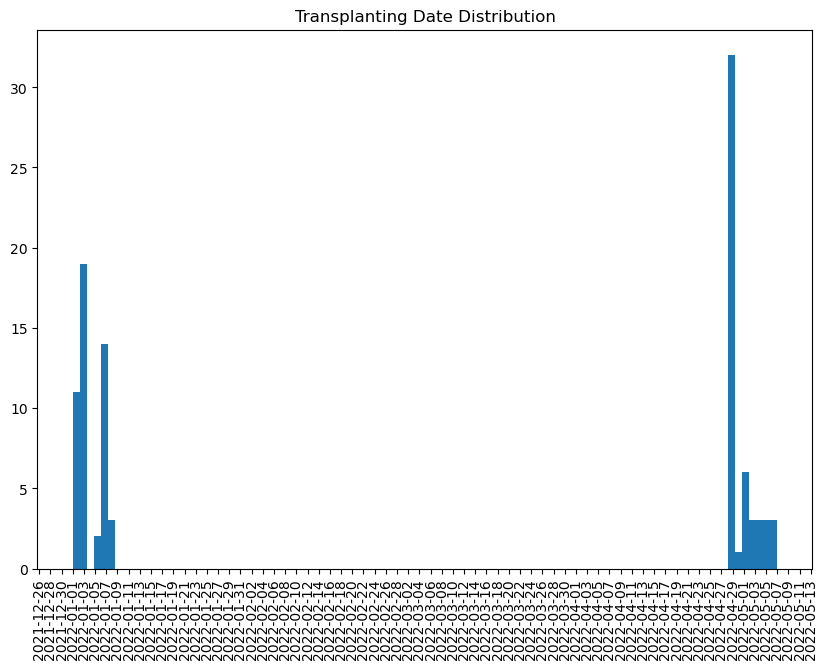

In [19]:
# Plot the distribution of transplanting dates
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(submission_filtered_sos, bins = 101)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.title("Transplanting Date Distribution")
plt.tick_params(axis='x', labelrotation=90)

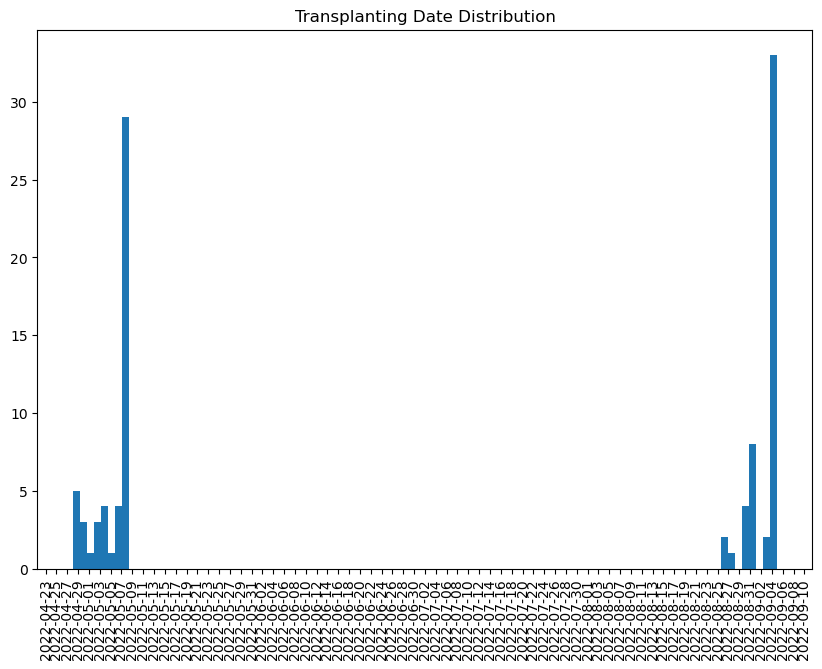

In [20]:
# Plot the distribution of harvesting dates
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(submission_filtered_eos, bins = 101)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.title("Transplanting Date Distribution")
plt.tick_params(axis='x', labelrotation=90)

In [14]:
def outlier_treatment_sos(filtered_sos):
    '''
    Return a list of cleaned transplanting dates with outlier treatment principles inferred from the above distribution plots
    '''
    
    filtered_sos_after_treatment = []
    for i, date in enumerate(filtered_sos):
        if date > datetime(2022,1,8) and date < datetime(2022, 4, 28):
            filtered_sos_after_treatment.append(datetime(2022,1,1))
        elif date <= datetime(2021, 12, 29):
            filtered_sos_after_treatment.append(datetime(2022,1,1))
        else:
            filtered_sos_after_treatment.append(date)
    return filtered_sos_after_treatment

def outlier_treatment_eos(filtered_eos):
    '''
    Return a list of cleaned harvesting dates with outlier treatment principles inferred from the above distribution plots
    '''
    
    filtered_eos_after_treatment = []
    for i, date in enumerate(filtered_eos):
        if date < datetime(2022, 8, 26) and date > datetime(2022,5,8):
            filtered_eos_after_treatment.append(datetime(2022,4,30))
        else:
            filtered_eos_after_treatment.append(date)
    return filtered_eos_after_treatment

In [15]:
# Get a list of cleaned transplanting dates with outlier treatment principles inferred from the above distribution plots
submission_filtered_sos = outlier_treatment_sos(submission_filtered_sos)

# Get a list of cleaned harvesting dates with outlier treatment principles inferred from the above distribution plots
submission_filtered_eos = outlier_treatment_eos(submission_filtered_eos)

In [16]:
def date_to_string(date_list):
    '''
    Return a list of dates converted into string format
    '''
    filtered_sos_string = []
    for date in date_list:
        ts = pd.to_datetime(str(date))
        d = ts.strftime('%Y-%m-%d')
        filtered_sos_string.append(d)
    return filtered_sos_string

In [17]:
# Get a dataframe of transplanting dates converted into string format
filtered_sos_string = pd.DataFrame(date_to_string(submission_filtered_sos), columns = ['sos'])

# Get a dataframe of harvesting dates converted into string format
filtered_eos_string = pd.DataFrame(date_to_string(submission_filtered_eos), columns = ['eos'])

# Add filtered_sos_string and filtered_eos_string as new columns to the test_file dataframe for convenience of downstream data queries
test_file = pd.concat([test_file,filtered_sos_string,filtered_eos_string], axis=1)

In [18]:
def get_sentinel_data_with_filtered_timeframe(longitude, latitude, box_size_deg, sos, eos, assests):
    
    '''
    Returns a list of VV,VH, VV/VH values for a given latitude and longitude over a given time period (based on the season)
    Attributes:
    longitude - Longitude
    latitude - Latitude
    season - The season for which band values need to be extracted.
    assets - A list of bands to be extracted
    
    '''
    
    bands_of_interest = assests
    time_slice = sos + '/' + eos
        
    vv_list_median = []
    vh_list_median = []
    vv_by_vh_list_mean = []
    vh_by_vv_list_mean = []
    rvi_list_mean = []
    
    bbox_of_interest = ((float(longitude)-box_size_deg/2), (float(latitude)-box_size_deg/2), (float(longitude)+box_size_deg/2), (float(latitude)+box_size_deg/2))
    time_of_interest = time_slice
    
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
    items = list(search.get_all_items())
    item = items[0]
    items.reverse()
    
    data = stac_load([items[1]],bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)

    for item in items:
        data = stac_load([item],bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326", resolution=10 / 111320.0)
        if(data['vh'].values[0][0][0]!=-32768.0 and data['vv'].values[0][0][0]!=-32768.0):
            data = data.where(~data.isnull(), 0)
            vh = data["vh"].astype("float64")
            vv = data["vv"].astype("float64")
            vv_list_median.append(np.median(vv))
            vh_list_median.append(np.median(vh))
            vv_by_vh_list_mean.append(np.mean(vv)/np.mean(vh))
            vh_by_vv_list_mean.append(np.mean(vh)/np.mean(vv))
            rvi_list_mean.append(((1 - np.mean(vv) / (np.mean(vv) + np.mean(vh))) ** 0.5) * 4 * (np.mean(vh) / (np.mean(vv) + np.mean(vh))))
    
    return vv_list_median, vh_list_median, vv_by_vh_list_mean, vh_by_vv_list_mean, rvi_list_mean

In [ ]:
## Get Sentinel-1-RTC Data
assests = ['vh','vv']
submission_train_band_values=test_file.progress_apply(lambda x: get_sentinel_data_with_filtered_timeframe(x['Longitude'], x['Latitude'],0.0004,x['sos'],x['eos'],assests), axis=1)
submission_vv_median = [x[0] for x in submission_train_band_values]
submission_vh_median = [x[1] for x in submission_train_band_values]
submission_vv_by_vh_mean = [x[2] for x in submission_train_band_values]
submission_vh_by_vv_mean = [x[3] for x in submission_train_band_values]
submission_rvi_mean = [x[4] for x in submission_train_band_values]

submission_vv_vh_rvi_data = pd.DataFrame(list(zip(submission_vv_median,submission_vh_median,submission_vv_by_vh_mean,submission_vh_by_vv_mean,submission_rvi_mean)),columns = ["vv_list_median","vh_list_median","vv/vh_list_mean","vh/vv_list_mean","rvi_list_mean"])

In [21]:
def ordinal_distribution(data, dx=3, dy=1, taux=1, tauy=1, return_missing=False, tie_precision=None):
    '''
    Returns
    -------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.
       
    Attributes
    ---------
    data : array 
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`.
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    return_missing: boolean
                    If `True`, it returns ordinal patterns not appearing in the 
                    symbolic sequence obtained from **data** are shown. If `False`,
                    these missing patterns (permutations) are omitted 
                    (default: `False`).
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
   
    '''
    def setdiff(a, b):
        '''
        Returns
        -------
        : array
            An array containing the elements in `a` that are not contained in `b`.
            
        Parameters
        ----------    
        a : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        b : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        '''

        a = np.asarray(a).astype('int64')
        b = np.asarray(b).astype('int64')

        _, ncols = a.shape

        dtype={'names':['f{}'.format(i) for i in range(ncols)],
            'formats':ncols * [a.dtype]}

        C = np.setdiff1d(a.view(dtype), b.view(dtype))
        C = C.view(a.dtype).reshape(-1, ncols)

        return(C)

    try:
        ny, nx = np.shape(data)
        data   = np.array(data)
    except:
        nx     = np.shape(data)[0]
        ny     = 1
        data   = np.array([data])

    if tie_precision is not None:
        data = np.round(data, tie_precision)

    partitions = np.concatenate(
        [
            [np.concatenate(data[j:j+dy*tauy:tauy,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
            for j in range(ny-(dy-1)*tauy)
        ]
    )

    symbols = np.apply_along_axis(np.argsort, 1, partitions)
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

    probabilities = symbols_count/len(partitions)

    if return_missing==False:
        return symbols, probabilities
    
    else:
        all_symbols   = list(map(list,list(itertools.permutations(np.arange(dx*dy)))))
        miss_symbols  = setdiff(all_symbols, symbols)
        symbols       = np.concatenate((symbols, miss_symbols))
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols.__len__())))
        
        return symbols, probabilities

In [22]:
def permutation_entropy(data, dx=3, dy=1, taux=1, tauy=1, base=2, normalized=True, probs=False, tie_precision=None):
    '''
    Returns Permutation Entropy
    Attributes:
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by :func:`ordpy.ordinal_distribution`).
    dx :   int
           Embedding dimension (horizontal axis) (default: 3).
    dy :   int
           Embedding dimension (vertical axis); it must be 1 for time series (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value 
                (default: `True`). If `False`, it is not.
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
    '''
    if not probs:
        _, probabilities = ordinal_distribution(data, dx, dy, taux, tauy, return_missing=False, tie_precision=tie_precision)
    else:
        probabilities = np.asarray(data)
        probabilities = probabilities[probabilities>0]

    if normalized==True and base in [2, '2']:        
        smax = np.log2(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log2(probabilities))
        return s/smax
         
    elif normalized==True and base=='e':        
        smax = np.log(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log(probabilities))
        return s/smax
    
    elif normalized==False and base in [2, '2']:
        return -np.sum(probabilities*np.log2(probabilities))
    else:
        return -np.sum(probabilities*np.log(probabilities))

In [23]:
def generate_stastical_features(dataframe):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    features_list = []
    for index, row in dataframe.iterrows():
        min_vv_median = min(row[0])
        max_vv_median = max(row[0])
        std_vv_median = np.std(row[0])
        range_vv_median = max_vv_median - min_vv_median
        mean_vv_median = np.mean(row[0])
        correlation_vv_median = sm.tsa.acf(row[0])[1]    
        permutation_entropy_vv_median = permutation_entropy(row[0], dx=6,base=2, normalized=True)
    
        min_vh_median = min(row[1])
        max_vh_median = max(row[1])
        std_vh_median = np.std(row[1])
        range_vh_median = max_vh_median - min_vh_median
        mean_vh_median = np.mean(row[1])
        correlation_vh_median = sm.tsa.acf(row[1])[1]
        permutation_entropy_vh_median = permutation_entropy(row[1], dx=6, base=2, normalized=True)
    
        min_vv_by_vh_mean = min(row[2])
        max_vv_by_vh_mean = max(row[2])
        std_vv_by_vh_mean = np.std(row[2])
        range_vv_by_vh_mean = max_vv_by_vh_mean - min_vv_by_vh_mean
        mean_vv_by_vh_mean = np.mean(row[2])
        correlation_vv_by_vh_mean = sm.tsa.acf(row[2])[1]
        permutation_entropy_vv_by_vh_mean = permutation_entropy(row[2], dx=6, base=2, normalized=True)
        
        min_rvi_mean = min(row[4])
        max_rvi_mean = max(row[4])
        std_rvi_mean = np.std(row[4])
        range_rvi_mean = max_rvi_mean - min_rvi_mean
        mean_rvi_mean = np.mean(row[4])
        correlation_rvi_mean = sm.tsa.acf(row[4])[1]
        permutation_entropy_rvi_mean = permutation_entropy(row[4], dx=6, base=2, normalized=True)
    
        features_list.append([min_vv_median, max_vv_median, std_vv_median, range_vv_median, mean_vv_median,
                              correlation_vv_median, permutation_entropy_vv_median,
                          min_vh_median, max_vh_median, std_vh_median, range_vh_median,  mean_vh_median,
                              correlation_vh_median, permutation_entropy_vh_median,
                          min_vv_by_vh_mean,  max_vv_by_vh_mean, std_vv_by_vh_mean, range_vv_by_vh_mean, mean_vv_by_vh_mean, 
                              correlation_vv_by_vh_mean, permutation_entropy_vv_by_vh_mean,
                          min_rvi_mean,  max_rvi_mean, std_rvi_mean, range_rvi_mean, mean_rvi_mean, 
                              correlation_rvi_mean, permutation_entropy_rvi_mean
                             ])
    return features_list

In [ ]:
# Generating Statistical Features for VV,VH and VV/VH and creating a dataframe
features = generate_stastical_features(submission_vv_vh_rvi_data)
submission_features_rvi_data = pd.DataFrame(features ,columns = ['min_vv_median', 'max_vv_median', 'std_vv_median', 'range_vv_median', 'mean_vv_median', 
                              'correlation_vv_median', 'permutation_entropy_vv_median',
                          'min_vh_median', 'max_vh_median', 'std_vh_median', 'range_vh_median',  'mean_vh_median', 
                              'correlation_vh_median', 'permutation_entropy_vh_median',
                          'min_vv_by_vh_mean',  'max_vv_by_vh_mean', 'std_vv_by_vh_median', 'range_vv_by_vh_mean', 'mean_vv_by_vh_mean', 
                              'correlation_vv_by_vh_mean', 'permutation_entropy_vv_by_vh_mean',
                          'min_rvi_mean',  'max_rvi_mean', 'std_rvi_mean', 'range_rvi_mean', 'mean_rvi_mean', 
                              'correlation_rvi_mean', 'permutation_entropy_rvi_mean'
                                                           ] )

In [ ]:
#Load the model from Pickle
pickled_model = pickle.load(open('model.pkl', 'rb'))

In [ ]:
#Making predictions
final_predictions = pickled_model.predict(submission_features_rvi_data.values)
final_prediction_series = pd.Series(final_predictions)

In [ ]:
#Combining the results into dataframe
test_file['Predicted Rice Yield (kg/ha)']=final_prediction_series

In [ ]:
#Dumping the predictions into a csv file.
test_file.to_csv("challenge_2_submission_rice_crop_yield_prediction.csv",index = False)